### Run onece, to check environment

In [1]:
#!pip3 install -r requirements.txt

### Scraper part, no need to run, just in case, can be adapted to other datasource
* Fit Erik's code into Scrapy(20 minutes now). Scraping publish time of news.

* To run it, put 'MINDlarge_train' in the top level directory of the project, which is 'DM-project'
  * don't submit MINDlarge_train, add it to gitignore

* Output filepath is 'DM-project/generate/newstimes.csv'

* Don't forget to go back to the top level directory

In [2]:
#%cd scraper

In [3]:
#!scrapy crawl news

In [4]:
#%cd ..

In [ ]:
#newsTimes = 'generate/newstimes.csv'

### Load Libraries

In [378]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [379]:
behaviors = 'MINDlarge_train/behaviors.tsv'
news = 'MINDlarge_train/news.tsv'
entityEmbedding = 'MINDlarge_train/entity_embedding.vec'

### Preprocssing, run once

In [8]:
#import preprocessing.preprocessing as pre

In [9]:
#generate news_embedding.csv, news_cleaned.csv
#pre.createNews(news,newsTimes,entityEmbedding)

#generate user_history.csv, user_impression.csv
#pre.createUsers(behaviors)

#split big files
#pre.splitFiles('generate/user_history.csv')
#pre.splitFiles('generate/user_impressions.csv')

### Categorical Embedding capture trending

In [ ]:
df_news = pd.read_csv('generate/news_cleaned.csv')
df_embeddings = pd.read_csv('generate/news_embedding.csv')

### Category embedding - solution 2

Use nlp embedding, tokenize subcategories
* i.e 
  * lifestylecelebrity-->lifestyle celebrity
  * finance-investing-->finance investing
  * football_fifa_wwc-->football fifa wwc
* I made it by hand,because only 284 of them. In real world messy data, we can applying hidden markov model to maximize likelihood of possibility chain.(idea from Chinese NLP segmentation)

* Pros:
  * Capture relations in context that is the relation across categories while one-hot encoding doesn't.
  * PinSage did so. They joint two embeddings ,vision embedding(picture) from CNN, context embedding(description, labels) from word2vec.

* Cons: 
  * Still 300 dimensions in a embedding vector. (spacy, here), if we do one-hot, 284 only.
       * PCA！ 

### No need to run, already generated, but in case you want to play around.
* generate/news_subcat_embedding_nlp.csv

In [22]:
#!pip3 install spacy

In [28]:
#!python3 -m spacy download en_core_web_lg

In [207]:
#subcategories = "generate/news_subcategories.csv"
#pre.createCategoriyEmbeddingNLP(subcategories)

fcluster### Clustering!

In [559]:
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist,cosine,cdist,squareform
import numpy.ma as ma

def clustering(X,vectorColumns,threshold,lam,withCentroid=False):
    ''' X 
            [dataframe] group of user history
        vectorColumns 
            [array like] embedding columns V1,V2....V300
        threshold
            [number] threshold for ward clustering
        lam 
            [number] paramter for importance sampling
       '''
    m,n = X.shape
    #print(X)
    if m>1:
        pairwise_distance = pdist(X[vectorColumns], metric='cosine')
        
        labels = fcluster(ward(pairwise_distance), t=threshold, criterion='distance')
        #print(labels)
        num_clusters = labels.max()
        
        scores = {}
        for i in range(num_clusters):
            c = i+1 #choose cluster
            #if we use sum, both consider number of item and time importance
            importance_score = X.loc[labels==c].importance.sum()
            scores[c] = importance_score
        
        if num_clusters>3:
            p = np.array(list(scores.values()))
            sum_score = p.sum()
            p /= sum_score
            chosed = np.random.choice(list(scores.keys()),p=p,size=3,replace=False)
        else:
            chosed = np.array(list(scores.keys()))
            
        
        medoids = []
        distance_upper_bound = []
        
        pairwise = squareform(pairwise_distance) 
        
        if withCentroid:
            centroids = []
           
            
        for c in chosed:
            idx = np.argwhere(labels==c).flatten()
            len_idx = len(idx)
        
            
            mask = np.ones(pairwise.shape,dtype=int)
            
            for j in idx:
                mask[j,idx]=0
            masked_pairwise = ma.array(pairwise, mask = mask)
            
            if withCentroid:
                mean_vector = X.loc[X.index[idx]][vectorColumns].mean().values
            
            if len_idx<3:
                distance_upper_bound.append(0.5)   
                medoids.append(X.loc[X.index[idx[0]]][vectorColumns].values)
                if withCentroid:
                    centroids.append(mean_vector) 
                continue
            min_distance_i = masked_pairwise.sum(axis=1).argmin()
            distances_i = masked_pairwise.compressed().reshape((len_idx,len_idx))[0]
            distances_i = distances_i[~(distances_i==0)]
            
            #68%-95%-99.8% for 1,2,3 std
            #!!!!!however
            #according to the result, larger cluster has lower std.
            
            distance_upper_bound.append(distances_i.mean()+2*distances_i.std())   
            medoids.append(X.loc[X.index[min_distance_i]][vectorColumns].values)
            
            if withCentroid:
                centroids.append(mean_vector)
            
        if withCentroid:
            return medoids,centroids,distance_upper_bound
        else:
            return medoids,distance_upper_bound
    else:
        if withCentroid:
            return X[vectorColumns].values,X[vectorColumns].values,0.5*np.ones(X.shape[0])
        else:
            return X[vectorColumns].values,0.5*np.ones(X.shape[0])

def clusteringBatch(history,t0,threshold=0.7,lam=0.01,withCentroid=False):
    df_news_embedding = pd.read_csv('generate/news_embedding.csv')
    df_news_meta = pd.read_csv('generate/news_cleaned.csv')
    
    df_history = pd.read_csv(history)
    
    
    #df_history = df_history[df_history.UID=='U1']
 
    df_history = df_history.merge(df_news_embedding,on='NID')
    df_history = df_history.merge(df_news_meta,on='NID')


    df_history['importance'] = np.exp(-lam*(t0-df_history.publishDate)/100000)

    vectorColumns = [c for c in df_history.columns if c.startswith('V')]

    if withCentroid:
        records_medoid = []
        records_centroid = []
        
        for UID,g in df_history.groupby('UID'):
            medoid,centroid,radius = clustering(g,vectorColumns,threshold,lam,withCentroid)
        
            len_centroid = len(centroid)
        
            for c in range(len_centroid):
                record = []
                record.append(UID)
                record+=centroid[c].tolist()
                record.append(radius[c])
                records_centroid.append(record)
                
                record = []
                record.append(UID)
                record+=medoid[c].tolist()
                record.append(radius[c])
                records_medoid.append(record)
        
        df_centroid = pd.DataFrame.from_records(records_centroid,columns=['UID']+vectorColumns+['radius'])
        df_medoid = pd.DataFrame.from_records(records_medoid,columns=['UID']+vectorColumns+['radius'])
        return df_medoid,df_centroid
    else:
        medoid,radius = clustering(g,vectorColumns,threshold,lam,withCentroid)
        
        len_medoid = len(medoid)
        
        for c in range(len_centroid):
            record = []
            record.append(UID)
            record+=centroid[c].tolist()
            record.append(radius[c])
            records_medoid.append(record)
                
        
        df_medoid = pd.DataFrame.from_records(records_medoid,columns=['UID']+vectorColumns+['radius'])
        return df_medoid

### what if use centroid of clustering as user representation

In [592]:
def measurement(impression,df_user_representation):
    df_impression = pd.read_csv(impression)
    df_impression = df_impression[df_impression.attitude==1]
    
    #df_impression = df_impression[df_impression.UID=='U1']
    
    df_news_embedding = pd.read_csv('generate/news_embedding.csv')
    df_impression = df_impression.merge(df_news_embedding,on='NID')
    
    vectorColumns = [c for c in df_impression.columns if c.startswith('V')]
        
    measure = []
    for UID,g in df_impression.groupby('UID'):
        
        user = df_user_representation[df_user_representation.UID==UID]
        
        if len(user)==0:
            continue
        
        user_radius = user.radius.values
        user = user[vectorColumns].values
        
        positive = g[vectorColumns]
        
        d = cdist(positive,user, metric='cosine')
       
        #at least one distance in radius
        hits = (d<user_radius).sum(axis=1)>0
        recall = hits.mean()
        
        hits_d = d[hits]
        where_clusters = hits_d.argmin(axis=1)
        
        hit = 1 - len(np.unique(where_clusters))/len(user)
       
        measure.append((UID,recall,hit))
        
    return pd.DataFrame.from_records(measure,columns=['UID','recall','percent_empty'])

### Medoid vs. Centroid

In [562]:
t0 = 1575586800+1000
lam = 0.01
threshold = 0.85

history = 'generate/user_history_1.csv'
impression = 'generate/user_impressions_1.csv'

df_user_representation_medoid,df_user_representation_centroid = clusteringBatch(history,t0,threshold=threshold,lam=lam,withCentroid=True)

In [593]:
df_measure_centroid = measurement(impression,df_user_representation_centroid)
df_measure_centroid.recall.mean()

0.703871600186037

In [594]:
df_measure_medoid = measurement(impression,df_user_representation_medoid)
df_measure_medoid.recall.mean()

0.6462028412568553

<AxesSubplot:>

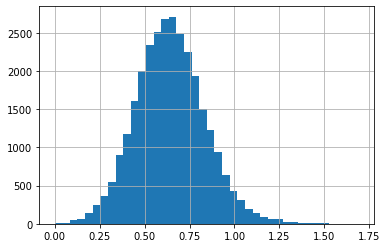

In [371]:
df_user_representation[~(df_user_representation.radius==0.5)].radius.hist(bins=40)